In [1]:
import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import RecalibratePredictions
from PREDICT.Metrics import *
from PREDICT.Triggers import SPCTrigger
from PREDICT.Plots import *

import pandas as pd
import datetime as dt
import numpy as np

# Statistical Process Control Example

In this scenario, we have predictions from an existing model but the underlying data changes due to the COVID pandemic.

This could mean that the model will perform worse due to changes in data seen by GPs as people have more flu symptoms or may be advised to visit their doctors less, leading to poorer predictions due to bad calibrations.

In this notebook we use statistical process control to determine when model recalibration should happen, using upper and lower control limits based on the model sum of differences error.

Recalibration is performed by fitting a logistic regression model to adjust the predictions (aka Platt scaling).

This notebook also shows examples of how to track changes to the input data over time, to help the identify what features may have led to model performance worsening. 

# Synthetic Data - COVID

We create some fake data to simulate a similar scenario to what happened during COVID-19:

1) From Jan 2019 - March 2020 flu symptoms occur but are not hugely prevalent.

2) From March 2020 COVID starts spreading increasing the number of health records with 'flu symptoms'.

3) June 2020 was when the pandemic peaked and cases were the highest.

4) And finally by June 2021 the recovery phase begins and less people have flu symptoms.

In [2]:
mydict = {
    'date': list(),
    'outcome': list(),
    'prediction': list(),
    'age': list(),
    'systolic_bp': list(),
    'flu_symptoms': list()
}

# Set random seed for reproducibility
np.random.seed(42)

# Define date range and COVID shock periods
startDate = pd.to_datetime('01-01-2019', dayfirst=True)  # Start a year before COVID
endDate = pd.to_datetime('31-12-2021', dayfirst=True)  # Include recovery period after COVID
switchDate = pd.to_datetime('01-03-2020', dayfirst=True)  # COVID starts spreading
switchDate2 = pd.to_datetime('01-06-2020', dayfirst=True)  # Peak of the pandemic
recoveryDate = pd.to_datetime('01-06-2021', dayfirst=True)  # Start of recovery phase
numdays = (endDate - startDate).days
switchDays = (switchDate - startDate).days
switch2Days = (switchDate2 - startDate).days
recoveryDays = (recoveryDate - startDate).days

for i in range(numdays):
    curday = startDate + dt.timedelta(days=i)

    age = np.random.normal(70, 5, 5000)  # Mean age 70 years, std 5
    systolic_bp = np.random.normal(120, 20, 5000)  # Mean systolic blood pressure 120 mmHg, std 10

    # Calculate baseline log-odds
    lp = -1.5 + 0.5 * (age - 70) / 5 + 2 * (systolic_bp - 120) / 10
    curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability

    # Simulate COVID effects
    if switchDays <= i < switch2Days:
        lp += 1.5  # Initial impact of COVID
    elif switch2Days <= i < recoveryDays:
        lp += 2.0  # Peak of the pandemic
    elif i >= recoveryDays:
        lp -= 1.0  # Recovery period—improved health outcomes

    # Simulate flu symptoms
    if i < switchDays:
        flu_symptoms = np.random.binomial(1, 0.1, 5000)  # Low baseline prevalence
    elif i < switch2Days:
        flu_symptoms = np.random.binomial(1, 0.3, 5000)  # Increased prevalence during COVID spread
    elif i < recoveryDays:
        flu_symptoms = np.random.binomial(1, 0.5, 5000)  # Higher prevalence during pandemic peak
    else:
        flu_symptoms = np.random.binomial(1, 0.2, 5000)  # Reduced prevalence during recovery

    # Generate outcomes
    curoutcomes = np.random.binomial(1, 1 / (1 + np.exp(-lp)))  # Simulate "heart attack" events

    # Append to dictionary
    mydict['date'].extend([curday] * 5000)
    mydict['outcome'].extend(curoutcomes)
    mydict['prediction'].extend(curpredictions)
    mydict['age'].extend(age)
    mydict['systolic_bp'].extend(systolic_bp)
    mydict['flu_symptoms'].extend(flu_symptoms)

df = pd.DataFrame(mydict)

df.head()


,date,outcome,prediction,age,systolic_bp,flu_symptoms
0,2019-01-01,0,0.049894,72.483571,111.524806,0
1,2019-01-01,0,0.032838,69.308678,110.931718,0
2,2019-01-01,0,0.000234,73.238443,84.087137,0
3,2019-01-01,0,0.113162,77.615149,113.398196,0
4,2019-01-01,1,0.788222,68.829233,134.656582,0


# Track the error over time and recalibrate when error enters the <span style="color: red;">red</span> zones

Messages are printed when the error reaches the <span style="color: yellow;">warning</span> zones suggesting the user investigates the cause of the error increasing, and a message is printed when the error reaches the <span style="color: red;">recalibration</span> zones telling the user that the model has been recalibrated.

The control limits can be generated by:

* using a set time period from the start date using ± x (warning zones) and ± y (recalibration zones) standard deviations from the mean (x and y are defaulted to 2 and 3 respectively)

* using a select period to calculate the warning and recalibration limits

* manually entering the warning and recalibration control limits



2020-03-31 00:00:00: Error is in the upper danger zone. 
The model has been recalibrated. 
You might want to investigate the cause of the error increasing.

2020-06-30 00:00:00: Error is in the upper danger zone. 
The model has been recalibrated. 
You might want to investigate the cause of the error increasing.

2021-06-30 00:00:00: Error is in the lower danger zone. 
The model has been recalibrated. 
You might want to investigate the cause of the error increasing.



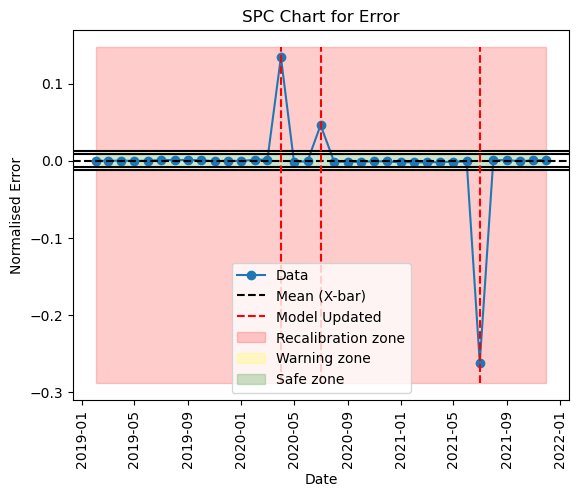

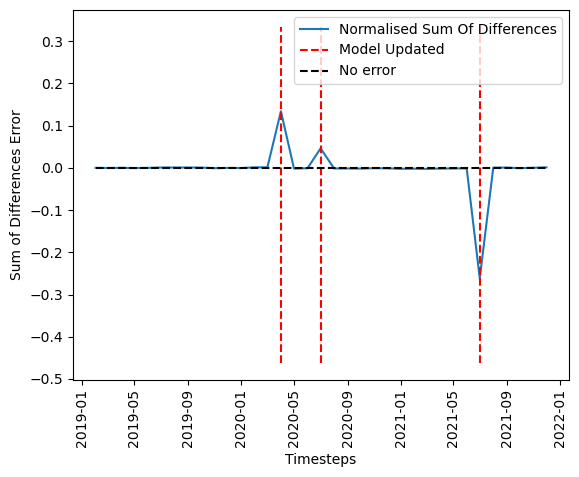

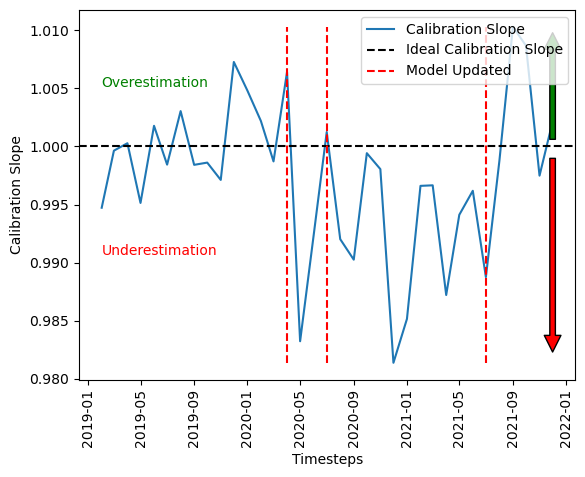

In [3]:
model = RecalibratePredictions()
model.trigger = SPCTrigger(model=model, input_data=df, numMonths=3)

mytest = PREDICT(data=df, model=model, startDate='min', endDate='max', timestep='month')
mytest.addLogHook(Accuracy(model))
mytest.addLogHook(CalibrationSlope(model))
mytest.addLogHook(CITL(model))
mytest.addLogHook(SumOfDiff(model))
mytest.run()
log = mytest.getLog()
ErrorSPCPlot(log, model)
NormalisedSumOfDiffPlot(log)
CalibrationSlopePlot(log)


# Monitor changes to the input data using dynamic statistical process control charts

In the two examples below we:

1) monitor changes to systolic blood pressure over time, plotting the average blood pressure each `week` and generating dynamic control limits from the mean of the last `20` weeks. Here we can see that the mean systolic blood pressure of the population is pretty stable and is likely to have caused changes to the model performance.


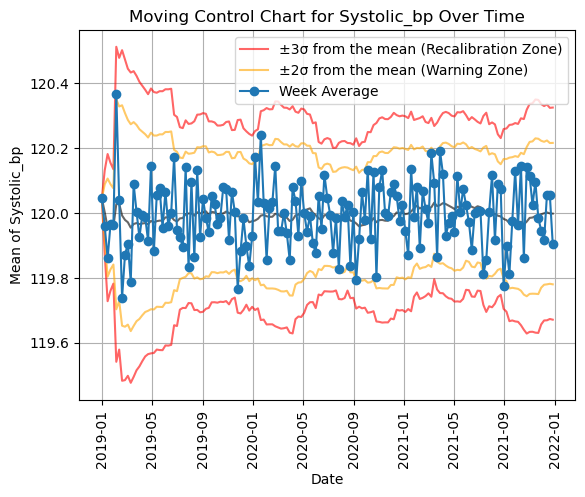

In [4]:
MonitorChangeSPC(input_data = df, trackCol='systolic_bp', timeframe='Week', windowSize=20)

2. monitor the prevalence of flu symptoms over time, plotting the prevalence over a `month` and generating dynamic control limits from the mean of the prior `3` months. Here we can see that flu symptoms increased around the same time as when the model started to perform more poorly, therefore flu symptom increase could be associated to reduce model performance.

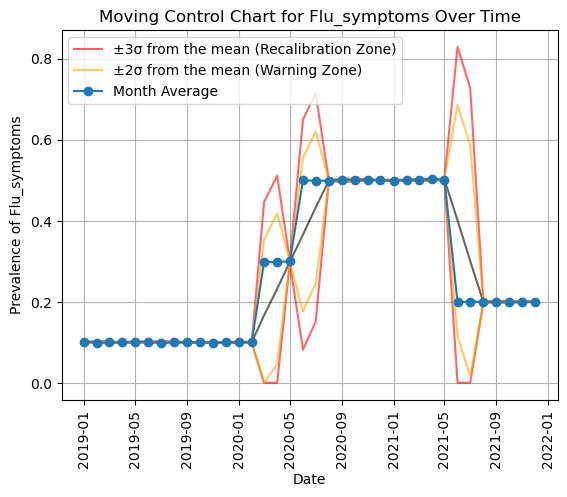

In [5]:
MonitorChangeSPC(input_data = df, trackCol='flu_symptoms', timeframe='Month', windowSize=3)